In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import xgboost as xgb

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train_indessa.csv')
test_data = pd.read_csv('test_indessa.csv')
loans = pd.concat([train_data,test_data])

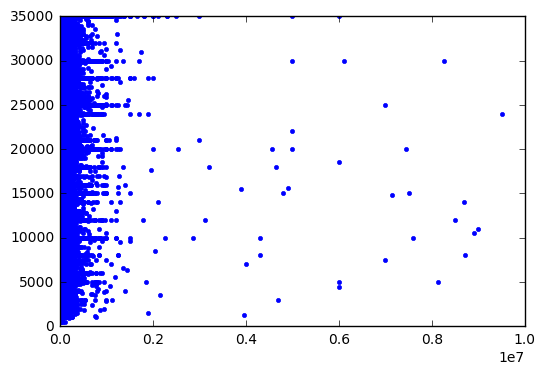

In [4]:
plt.plot(loans['annual_inc'],loans['funded_amnt'],'.')
plt.show()

In [5]:
safe = sum(loans['loan_status']==0)
safe
risky = sum(loans['loan_status']==1)
perc = risky/(safe+risky)
perc

0.23632678972555915

In [6]:
loans['loan_status'].iloc[532427]

0.0

In [7]:
loans['annual_inc'] = loans['annual_inc'].fillna(loans['annual_inc'].mean())

In [8]:
def update(item):
    s = ''.join(x for x in item if x.isdigit())
    if(len(s)!=0):
        return int(s)
    else:
        return 0

In [9]:
loans['emp_length'] = loans['emp_length'].apply(lambda x:update(x))

In [10]:
features = loans.columns.values
print(features)

['acc_now_delinq' 'addr_state' 'annual_inc' 'application_type'
 'batch_enrolled' 'collection_recovery_fee' 'collections_12_mths_ex_med'
 'delinq_2yrs' 'desc' 'dti' 'emp_length' 'emp_title' 'funded_amnt'
 'funded_amnt_inv' 'grade' 'home_ownership' 'initial_list_status'
 'inq_last_6mths' 'int_rate' 'last_week_pay' 'loan_amnt' 'loan_status'
 'member_id' 'mths_since_last_delinq' 'mths_since_last_major_derog'
 'mths_since_last_record' 'open_acc' 'pub_rec' 'purpose' 'pymnt_plan'
 'recoveries' 'revol_bal' 'revol_util' 'sub_grade' 'term' 'title'
 'tot_coll_amt' 'tot_cur_bal' 'total_acc' 'total_rec_int'
 'total_rec_late_fee' 'total_rev_hi_lim' 'verification_status'
 'verification_status_joint' 'zip_code']


In [11]:
loans.columns[loans.isnull().any()].tolist()

['acc_now_delinq',
 'batch_enrolled',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'desc',
 'emp_title',
 'inq_last_6mths',
 'loan_status',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_util',
 'title',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_acc',
 'total_rev_hi_lim',
 'verification_status_joint']

In [12]:
# delinquence_2 years no of times overdue in past 2 years
loans['delinq_2yrs'] = loans['delinq_2yrs'].fillna(0)
loans['delinq_2yrs'].describe()

count    887379.000000
mean          0.314432
std           0.862232
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: delinq_2yrs, dtype: float64

In [13]:
# number of inquiries in last 6 months
loans['inq_last_6mths'] = loans['inq_last_6mths'].fillna(1)
loans['inq_last_6mths'].describe()

count    887379.000000
mean          0.694633
std           0.998433
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          33.000000
Name: inq_last_6mths, dtype: float64

In [14]:
# months since last deliquency
loans['mths_since_last_delinq'] = loans['mths_since_last_delinq'].fillna(0)
loans['mths_since_last_delinq'].describe()

count    887379.000000
mean         16.624134
std          22.883648
min           0.000000
25%           0.000000
50%           0.000000
75%          30.000000
max         188.000000
Name: mths_since_last_delinq, dtype: float64

In [15]:
loans['mths_since_last_record'].describe()
perc = sum(loans['mths_since_last_record'].isnull())
perc = perc/len(loans)
perc
# we not taking this for modeling out model since it misses 84% of whole data which is very large

0.84555302751135653

In [16]:
# no of times borrowed money from credit line type loan 
loans['open_acc'] = loans['open_acc'].fillna(loans['open_acc'].mean())
loans['open_acc'].describe()

count    887379.000000
mean         11.548469
std           5.317226
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64

In [17]:
#no of derogatory public records
loans['pub_rec'] = loans['pub_rec'].fillna(0)
loans['pub_rec'].describe()

count    887379.000000
mean          0.195301
std           0.582082
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

In [18]:
# revolving utilization
loans['revol_util'] = loans['revol_util'].fillna(loans['revol_util'].mean())

In [19]:
# total credit lines available in member credit line
loans['total_acc'] = loans['total_acc'].fillna(loans['total_acc'].mean())
loans['total_acc'].describe()

count    887379.000000
mean         25.268026
std          11.840368
min           1.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         169.000000
Name: total_acc, dtype: float64

In [20]:
# collection items excluding medical 
# lower the collection item more the chance of approval
loans['collections_12_mths_ex_med'] = loans['collections_12_mths_ex_med'].fillna(0)
loans['collections_12_mths_ex_med'].describe()

count    887379.000000
mean          0.014377
std           0.134180
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: collections_12_mths_ex_med, dtype: float64

In [21]:
loans['mths_since_last_major_derog'].describe()
perc = sum(loans['mths_since_last_major_derog'].isnull())/len(loans)
perc
# as we see more than 75% data is missing so this feature is not useful in predicting model

0.75015974008850783

In [22]:
loans['verification_status_joint'].describe()
# leaving this also

count              511
unique               3
top       Not Verified
freq               283
Name: verification_status_joint, dtype: object

In [23]:
# no of deliquent account
loans['acc_now_delinq'] = loans['acc_now_delinq'].fillna(0)
loans['acc_now_delinq'].describe()

count    887379.000000
mean          0.004991
std           0.077624
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.000000
Name: acc_now_delinq, dtype: float64

In [24]:
# total collection ammont we are considering to be mean for time being
loans['tot_coll_amt'] = loans['tot_coll_amt'].fillna(loans['tot_coll_amt'].mean())
loans['tot_coll_amt'].describe()

count    8.873790e+05
mean     2.257026e+02
std      9.894641e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [25]:
#total current balance of all accounts
loans['tot_cur_bal'] = loans['tot_cur_bal'].fillna(loans['tot_cur_bal'].mean())
loans['tot_cur_bal'].describe()

count    8.873790e+05
mean     1.394582e+05
std      1.475363e+05
min      0.000000e+00
25%      3.224600e+04
50%      1.000890e+05
75%      1.957940e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [26]:
# revolving card limit
loans['total_rev_hi_lim'] = loans['total_rev_hi_lim'].fillna(loans['total_rev_hi_lim'].mean())
loans['total_rev_hi_lim'].describe()

count    8.873790e+05
mean     3.206862e+04
std      3.598280e+04
min      0.000000e+00
25%      1.470000e+04
50%      2.580000e+04
75%      3.780000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64

In [27]:
loans.head()

,acc_now_delinq,addr_state,annual_inc,application_type,batch_enrolled,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,desc,dti,...,title,tot_coll_amt,tot_cur_bal,total_acc,total_rec_int,total_rec_late_fee,total_rev_hi_lim,verification_status,verification_status_joint,zip_code
0,0.0,FL,28700.0,INDIVIDUAL,,0.0,0.0,0.0,NaN,33.88,...,Debt consolidation,0.0,28699.0,28.0,1173.84,0.0,30800.0,Source Verified,NaN,349xx
1,0.0,MD,65000.0,INDIVIDUAL,BAT1586599,0.0,0.0,0.0,NaN,3.64,...,Home improvement,0.0,9974.0,13.0,83.95,0.0,32900.0,Source Verified,NaN,209xx
2,0.0,OH,45000.0,INDIVIDUAL,BAT1586599,0.0,0.0,0.0,NaN,18.42,...,Debt consolidation,65.0,38295.0,19.0,56.47,0.0,34900.0,Not Verified,NaN,447xx
3,0.0,VA,105000.0,INDIVIDUAL,BAT4808022,0.0,0.0,0.0,> My goal is to obtain a loan to pay off my hi...,14.97,...,Debt consolidation,0.0,55564.0,21.0,4858.62,0.0,24700.0,Not Verified,NaN,221xx
4,0.0,CA,52000.0,INDIVIDUAL,BAT2833642,0.0,0.0,0.0,NaN,20.16,...,refi,0.0,47159.0,27.0,2296.41,0.0,47033.0,Verified,NaN,900xx


In [28]:
numerical_features = loans.select_dtypes(exclude=['object']).columns
categorical_features = loans.select_dtypes(include=['object']).columns
print(numerical_features)
print(categorical_features)

Index(['acc_now_delinq', 'annual_inc', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'emp_length',
       'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'int_rate',
       'loan_amnt', 'loan_status', 'member_id', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'recoveries', 'revol_bal', 'revol_util', 'tot_coll_amt',
       'tot_cur_bal', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'total_rev_hi_lim'],
      dtype='object')
Index(['addr_state', 'application_type', 'batch_enrolled', 'desc', 'emp_title',
       'grade', 'home_ownership', 'initial_list_status', 'last_week_pay',
       'purpose', 'pymnt_plan', 'sub_grade', 'term', 'title',
       'verification_status', 'verification_status_joint', 'zip_code'],
      dtype='object')


In [29]:
numeric_important = ['loan_amnt','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','mths_since_last_delinq',
                     'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int',
                     'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','collections_12_mths_ex_med',
                     'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'
                    ]
category_important = ['term','grade','home_ownership','verification_status','title']

In [30]:
for col in category_important:
    print(col,':')
    print(loans[col].value_counts(),'\n')

term :
36 months    621125
60 months    266254
Name: term, dtype: int64 

grade :
B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64 

home_ownership :
MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64 

verification_status :
Source Verified    329558
Verified           291071
Not Verified       266750
Name: verification_status, dtype: int64 

title :
Debt consolidation                          414352
Credit card refinancing                     164341
Home improvement                             40170
Other                                        31892
Debt Consolidation                           16414
Major purchase                               12051
Business                                      6746
Medical expenses                              6675
Consolidation                                 5675
Car financing                

In [31]:
# since title contains too many unique values drop it
category_important.remove('title')
print(category_important)

['term', 'grade', 'home_ownership', 'verification_status']


In [32]:
total = category_important+numeric_important
print(total)
df_imp = loans[total]
df_imp.head()

['term', 'grade', 'home_ownership', 'verification_status', 'loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


,term,grade,home_ownership,verification_status,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,36 months,E,OWN,Source Verified,14350,9,28700.0,33.88,0.0,1.0,...,28.0,1173.84,0.0,0.0,0.0,0.0,0.0,0.0,28699.0,30800.0
1,36 months,B,MORTGAGE,Source Verified,4800,1,65000.0,3.64,0.0,1.0,...,13.0,83.95,0.0,0.0,0.0,0.0,0.0,0.0,9974.0,32900.0
2,36 months,A,OWN,Not Verified,10000,2,45000.0,18.42,0.0,0.0,...,19.0,56.47,0.0,0.0,0.0,0.0,0.0,65.0,38295.0,34900.0
3,36 months,D,RENT,Not Verified,15000,10,105000.0,14.97,0.0,2.0,...,21.0,4858.62,0.0,0.0,0.0,0.0,0.0,0.0,55564.0,24700.0
4,36 months,B,RENT,Verified,16000,10,52000.0,20.16,0.0,0.0,...,27.0,2296.41,0.0,0.0,0.0,0.0,0.0,0.0,47159.0,47033.0


In [33]:
# A<B<C<D<E<F<G
mapping_dict = {
    "grade":{
        "A": 7,
        "B": 6,
        "C": 5,
        "D": 4,
        "E": 3,
        "F": 2,
        "G": 1
    }
}
df_imp = df_imp.replace(mapping_dict)
df_imp.head()

,term,grade,home_ownership,verification_status,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,36 months,3,OWN,Source Verified,14350,9,28700.0,33.88,0.0,1.0,...,28.0,1173.84,0.0,0.0,0.0,0.0,0.0,0.0,28699.0,30800.0
1,36 months,6,MORTGAGE,Source Verified,4800,1,65000.0,3.64,0.0,1.0,...,13.0,83.95,0.0,0.0,0.0,0.0,0.0,0.0,9974.0,32900.0
2,36 months,7,OWN,Not Verified,10000,2,45000.0,18.42,0.0,0.0,...,19.0,56.47,0.0,0.0,0.0,0.0,0.0,65.0,38295.0,34900.0
3,36 months,4,RENT,Not Verified,15000,10,105000.0,14.97,0.0,2.0,...,21.0,4858.62,0.0,0.0,0.0,0.0,0.0,0.0,55564.0,24700.0
4,36 months,6,RENT,Verified,16000,10,52000.0,20.16,0.0,0.0,...,27.0,2296.41,0.0,0.0,0.0,0.0,0.0,0.0,47159.0,47033.0


In [34]:
#convert nominal features to one hot encoded dummies
df_imp = pd.get_dummies(df_imp)
df_imp.head()

,grade,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,...,term_60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,3,14350,9,28700.0,33.88,0.0,1.0,50.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,6,4800,1,65000.0,3.64,0.0,1.0,0.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,10000,2,45000.0,18.42,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,15000,10,105000.0,14.97,0.0,2.0,46.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,6,16000,10,52000.0,20.16,0.0,0.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [35]:
print(df_imp.count())

grade                                  887379
loan_amnt                              887379
emp_length                             887379
annual_inc                             887379
dti                                    887379
delinq_2yrs                            887379
inq_last_6mths                         887379
mths_since_last_delinq                 887379
open_acc                               887379
pub_rec                                887379
revol_bal                              887379
revol_util                             887379
total_acc                              887379
total_rec_int                          887379
total_rec_late_fee                     887379
recoveries                             887379
collection_recovery_fee                887379
collections_12_mths_ex_med             887379
acc_now_delinq                         887379
tot_coll_amt                           887379
tot_cur_bal                            887379
total_rev_hi_lim                  

In [36]:
train_data = df_imp[:532428]
test_data = df_imp[532428:]
print(train_data.shape,test_data.shape)

(532428, 33) (354951, 33)


In [37]:
train_data['loan_status'] = (loans['loan_status'])[:532428]
train_data = train_data.sample(frac=1.0)
print(train_data.shape)

(532428, 34)


In [38]:
safe_loans_raw = train_data[train_data['loan_status']==0]
risky_loans_raw = train_data[train_data['loan_status']==1]
per = len(risky_loans_raw)/(float(len(safe_loans_raw)))
print(per)
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=per)
train_data = pd.concat([safe_loans,risky_loans])
train_data = train_data.sample(frac=1.0)
print('safe_loans',len(safe_loans)/len(train_data))
print('risky_loans',len(risky_loans)/len(train_data))
print(len(train_data))
train_target= train_data['loan_status']
print(train_target.shape)

0.3094606260191195
safe_loans 0.5
risky_loans 0.5
251654
(251654,)


In [39]:
dfs = []
target = []
j = 0
x = 25165
k = x;
for i in range(1,11):
    if(i!=10):
        temp = train_data[j:k]
        temp1 = train_target[j:k]
    else:
        temp = train_data[j:]
        temp1 = train_target[j:]
    dfs.append(temp)
    target.append(temp1)
    print(j,k)
    j = k
    k +=x    

0 25165
25165 50330
50330 75495
75495 100660
100660 125825
125825 150990
150990 176155
176155 201320
201320 226485
226485 251650


In [40]:
params={
    'objective':'binary:logistic',
    'max_depth':2,
    'silent':1,
    'eta':1
}
num_rounds = 5

In [51]:
temp_data = dfs[0]
# temp_data = temp_data.drop('loan_status',1)
temp_target = train_target[:25165]
print(temp_data.shape,temp_target.shape)

(25165, 34) (25165,)


In [56]:
dtrain = xgb.DMatrix(temp_data)

In [55]:
print(dtrain.num_row(),dtrain.num_col())

25165 34


In [57]:
model = xgb.train(params,dtrain,num_rounds)

XGBoostError: b'[11:00:00] src/objective/regression_obj.cc:89: Check failed: info.labels.size() != 0U (0 vs. 0) label set cannot be empty'

In [49]:
preds_prob = model.predict(dfs[1].drop('loan_status',1))
preds_prob

NameError: name 'model' is not defined

In [101]:
# model1 = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_samples_split=2,min_samples_leaf=1)
# model2 = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=2,min_samples_leaf=1,class_weight='balanced_subsample')
# model = xgb.XGBClassifier(n_estimators=1000,max_depth=5)
# model4 = AdaBoostClassifier(n_estimators=150,learning_rate=1)
# model5 = DecisionTreeClassifier(max_depth=5,min_samples_split=2,min_samples_leaf=1)
#model6 = SVC(probability=True,class_weight='balanced')

In [102]:
# model1.fit(temp_data,temp_target)
# model2.fit(temp_data,temp_target)
# model3.fit(temp_data,temp_target)
# model4.fit(temp_data,temp_target)
# model5.fit(temp_data,temp_target)
model.fit(temp_data,temp_target)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
# feature_importance = (temp_data.columns.values).tolist()
# feature_weight = model.feature_importances_
# for i in range(len(feature_importance)):
#     print(feature_importance[i]+"-------------------------------> "+str(feature_weight[i]))
for i in range(1,len(target)):
    score = model.score(dfs[i].drop('loan_status',1),target[i])
#     prediction = model.predict(dfs[i].drop('loan_status',1))
#     confusion_matrix = confusion_matrix(target[i],prediction)
    print(score)

0.689370156964
0.6978581363
0.690435128154
0.688464136698
0.69353467117
0.6919054242
0.686389827141
0.68971190145
0.69173983869


In [85]:
test = pd.read_csv('test_indessa.csv')

In [87]:
print(test_data.shape)

(354951, 33)


In [88]:
prediction1 = model1.predict_proba(test_data)[:,1]
prediction2 = model2.predict_proba(test_data)[:,1]
prediction3 = model3.predict_proba(test_data)[:,1]
prediction4 = model4.predict_proba(test_data)[:,1]
prediction5 = model5.predict_proba(test_data)[:,1]

In [89]:
prediction=[]
for i in range(len(prediction1)):
    x = prediction1[i]+prediction2[i]+prediction3[i]+prediction4[i]+prediction5[i]
    x = x/5
    prediction.append(x)   

0.416734477771


In [93]:
print(prediction[0]) 
a = np.asarray(prediction)
a = a.reshape(len(a),1)
print(a.shape)

0.357411798016
(354951, 1)


In [94]:
df= pd.DataFrame()
df['member_id'] = test['member_id']
df['loan_status'] = a
df.head()

,member_id,loan_status
0,11937648,0.357412
1,38983318,0.416734
2,27999917,0.304764
3,61514932,0.308122
4,59622821,0.484389


In [95]:
df.to_csv('Xgboost.csv',index=False)